In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sklearn
print("Sklearn verion is {}".format(sklearn.__version__))

Sklearn verion is 1.0.2


In [3]:
df_data = pd.read_csv("feature_dataset/Dataset_an.csv")

In [4]:
feat = []
for i in df_data.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)

In [5]:
def lgb_p(x):
    y = 0
    if x > 0.5:
        y = 1
    return y

# lightgbm

In [6]:
kfold = StratifiedKFold(n_splits=5,random_state=1024, shuffle=True).split(df_data[feat],df_data["ps"])
lgb_answer = []
lgb_answer_recall = []

for fold, (train_idx, valid_idx) in enumerate(kfold):
    df = pd.DataFrame()
    X_train, y_train = df_data[feat].iloc[train_idx], df_data["ps"].iloc[train_idx]
    X_valid, y_valid = df_data[feat].iloc[valid_idx], df_data["ps"].iloc[valid_idx]

    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)

    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}

    bst = lgb.train(param, train_lgb)

    y_pred = bst.predict(X_valid)
    df["lgb"] = y_pred
    df["x"] = df["lgb"].apply(lambda x:lgb_p(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,list(df["x"]))
    test_auc = metrics.auc(fpr, tpr)
    d = metrics.recall_score(y_valid, df["x"], average='micro')
    lgb_answer.append(test_auc)
    lgb_answer_recall.append(d)
    print("lgb_answer",test_auc)
    print("lgb_answer_recall",d)

[LightGBM] [Info] Number of positive: 176, number of negative: 324
[LightGBM] [Info] Total Bins 54905
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352000 -> initscore=-0.610260
[LightGBM] [Info] Start training from score -0.610260
lgb_answer 0.9421997755331089
lgb_answer_recall 0.952
[LightGBM] [Info] Number of positive: 176, number of negative: 324
[LightGBM] [Info] Total Bins 54920
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352000 -> initscore=-0.610260
[LightGBM] [Info] Start training from score -0.610260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
lgb_answer 0.9587542087542088
lgb_answer_recall 0.96
[LightGBM] [Info] Number of positive: 176, number of negative: 324
[LightGBM] [Info] Total Bins 54928
[LightGBM] [Info] Number of data points in the train set: 50

# Xgb

In [7]:
kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_data[feat],df_data["ps"])
xgb_answer = []
xgb_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    X_train, y_train = df_data[feat].iloc[train_idx], df_data["ps"].iloc[train_idx]
    X_valid, y_valid = df_data[feat].iloc[valid_idx], df_data["ps"].iloc[valid_idx]

    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)

    model.fit(X_train,y_train,
              eval_metric="auc")
    y_pred = model.predict(X_valid)
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,y_pred)
    test_auc = metrics.auc(fpr, tpr)
    d = metrics.recall_score(y_valid, y_pred, average='micro')
    xgb_answer.append(test_auc)
    xgb_answer_recall.append(d)
    print(test_auc)
    print(d)

0.9360269360269362
0.944
0.9483726150392817
0.96
0.9402356902356903
0.936
0.9421997755331089
0.952
0.9184904601571268
0.928


# Catboost

In [8]:
kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_data[feat],df_data["ps"])
catboost_answer = []
catboost_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    X_train, y_train = df_data[feat].iloc[train_idx], df_data["ps"].iloc[train_idx]
    X_valid, y_valid = df_data[feat].iloc[valid_idx], df_data["ps"].iloc[valid_idx]

    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7,
                early_stopping_rounds=500

            )


    clf = model.fit(X_train,y_train,verbose=500)
    predict_prob_y = clf.predict(X_valid)
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,predict_prob_y)
    test_auc = metrics.auc(fpr, tpr)
    d = metrics.recall_score(y_valid, predict_prob_y, average='micro')
    catboost_answer.append(test_auc)
    catboost_answer_recall.append(d)
    print(test_auc)
    print(d)

0:	total: 59.3ms	remaining: 59.3ms
1:	total: 83.6ms	remaining: 0us
0.9308361391694724
0.944
0:	total: 14.9ms	remaining: 14.9ms
1:	total: 28.8ms	remaining: 0us
0.861672278338945
0.888
0:	total: 13.7ms	remaining: 13.7ms
1:	total: 27.7ms	remaining: 0us
0.9061447811447811
0.912
0:	total: 14.1ms	remaining: 14.1ms
1:	total: 28.2ms	remaining: 0us
0.9535634118967452
0.96
0:	total: 14.6ms	remaining: 14.6ms
1:	total: 28.5ms	remaining: 0us
0.9236812570145904
0.928


# Random Forests

In [9]:
kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_data[feat],df_data["ps"])
RandomForest_answer = []
RandomForest_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    X_train, y_train = df_data[feat].iloc[train_idx], df_data["ps"].iloc[train_idx]
    X_valid, y_valid = df_data[feat].iloc[valid_idx], df_data["ps"].iloc[valid_idx]

    #XX_valid,test_X,yy_valid,test_y = train_test_split(X_valid,y_valid,
    #                                                test_size=0.5,random_state=2020)

    
    model = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = model.fit(X_train,y_train)
    predict_prob_y = clf.predict(X_valid)
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,predict_prob_y)
    test_auc = metrics.auc(fpr, tpr)
    d = metrics.recall_score(y_valid, predict_prob_y, average='micro')
    RandomForest_answer.append(test_auc)
    RandomForest_answer_recall.append(d)
    print(test_auc)

0.9483726150392817
0.9412177328843995
0.9236812570145904
0.9483726150392817
0.8957631874298541


# vote

In [10]:
feat = []
for i in df_data.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)
kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_data[feat],df_data["ps"])
vote_answer = []
vote_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    df11 = pd.DataFrame()
    X_train, y_train = df_data[feat].iloc[train_idx], df_data["ps"].iloc[train_idx]
    X_valid, y_valid = df_data[feat].iloc[valid_idx], df_data["ps"].iloc[valid_idx]

    #XX_valid,test_X,yy_valid,test_y = train_test_split(X_valid,y_valid,
    #                                                 test_size=0.5,random_state=2020)
    rf = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = rf.fit(X_train,y_train)
    rf_y = clf.predict(X_valid)
    
    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7)

    clf = model.fit(X_train,y_train,verbose=500)
    cat_y = clf.predict(X_valid)
    
    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)
    
    model.fit(X_train,y_train,
              eval_metric="auc")
    xgb_y = model.predict(X_valid)
    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)
    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}
    bst = lgb.train(param, train_lgb)
    y_pred = bst.predict(X_valid)
    df11["lgb"] = y_pred
    lgb_y = df11["lgb"].apply(lambda x:lgb_p(x))
    
    def vote(x):
            y = 0
            if abs(x) > 2:
                y = 1
            return y
        
    df_cat = pd.DataFrame(cat_y)
    df_xgb = pd.DataFrame(xgb_y)
    df_rf = pd.DataFrame(rf_y)
    df_lgb = pd.DataFrame(list(lgb_y))
    df = pd.DataFrame(df_lgb[0]*3 + df_xgb[0]*2 + df_rf[0]*2 + df_cat[0]*1)
    df[1] = df[0].apply(lambda x : vote(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,df[1])
    d = metrics.recall_score(y_valid, df[1], average='micro')
    test_auc = metrics.auc(fpr, tpr)
    vote_answer.append(test_auc)
    vote_answer_recall.append(d)
    print("aaaaa:",test_auc)

0:	total: 14.4ms	remaining: 14.4ms
1:	total: 28.1ms	remaining: 0us
[LightGBM] [Info] Number of positive: 176, number of negative: 324
[LightGBM] [Info] Total Bins 54905
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352000 -> initscore=-0.610260
[LightGBM] [Info] Start training from score -0.610260
aaaaa: 0.9421997755331089
0:	total: 13.3ms	remaining: 13.3ms
1:	total: 27.7ms	remaining: 0us
[LightGBM] [Info] Number of positive: 176, number of negative: 324
[LightGBM] [Info] Total Bins 54920
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352000 -> initscore=-0.610260
[LightGBM] [Info] Start training from score -0.610260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
aaaaa: 0.9639450056116723
0:	total: 13.3ms	remaining: 13.3ms
1:	total: 27.6ms	remaining: 0us
[LightGBM] [Info

# 可视化

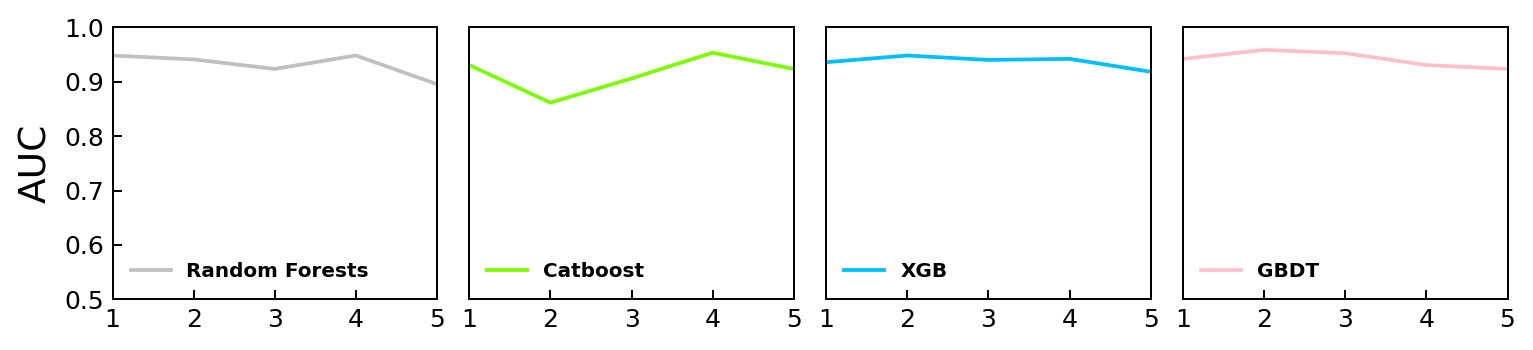

In [11]:
fig = plt.figure(figsize=(10,2),dpi=180)
# 创建子图1
x=[1,2,3,4,5]
sub1 = fig.add_subplot(1,4,1)
plt.ylabel("AUC",{"size":15})
plt.tick_params(direction='in')
plt.ylim((0.5, 1))
plt.xlim((1, 5))
sub1.plot(x,RandomForest_answer,label ="Random Forests", color='silver')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})
 
#创建子图2
sub3 = fig.add_subplot(1,4,2)
plt.ylim((0.5, 1))
plt.xlim((1, 5))
plt.tick_params(direction='in')
plt.yticks([])  #去掉y轴
sub3.plot(x,catboost_answer,label ="Catboost", color='lawngreen')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})
 
#创建子图3
sub4 = fig.add_subplot(1,4,3)
plt.ylim((0.5, 1))
plt.xlim((1, 5))
plt.tick_params(direction='in')
plt.yticks([])  #去掉y轴
sub4.plot(x,xgb_answer,label ="XGB", color='deepskyblue')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})

#创建子图4
sub5 = fig.add_subplot(1,4,4)
plt.yticks([])  #去掉y轴
plt.ylim((0.5, 1))
plt.xlim((1, 5))
plt.tick_params(direction='in')
sub5.plot(x,lgb_answer,label ="GBDT", color='pink')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})

plt.subplots_adjust(hspace=0.4,wspace=0.1)
plt.show()

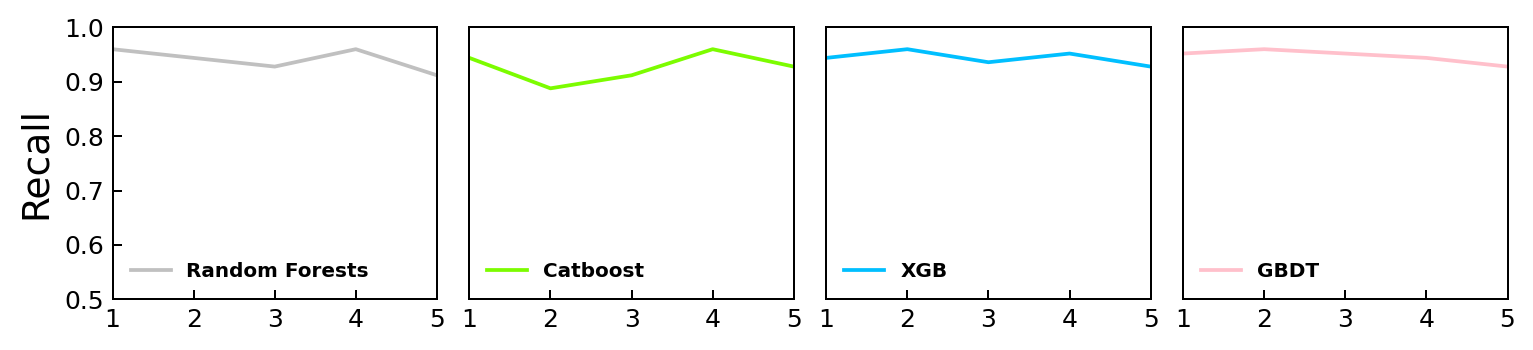

In [12]:
fig = plt.figure(figsize=(10,2),dpi=180)
# 创建子图1
x=[1,2,3,4,5]
sub1 = fig.add_subplot(1,4,1)
plt.ylabel("Recall",{"size":15})
plt.tick_params(direction='in')
plt.ylim((0.5, 1))
plt.xlim((1, 5))
sub1.plot(x,RandomForest_answer_recall,label ="Random Forests", color='silver')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})
 
#创建子图2
sub3 = fig.add_subplot(1,4,2)
plt.ylim((0.5, 1))
plt.xlim((1, 5))
plt.tick_params(direction='in')
plt.yticks([])  #去掉y轴
sub3.plot(x,catboost_answer_recall,label ="Catboost", color='lawngreen')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})
 
#创建子图3
sub4 = fig.add_subplot(1,4,3)
plt.ylim((0.5, 1))
plt.xlim((1, 5))
plt.tick_params(direction='in')
plt.yticks([])  #去掉y轴
sub4.plot(x,xgb_answer_recall,label ="XGB", color='deepskyblue')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})

#创建子图4
sub5 = fig.add_subplot(1,4,4)
plt.yticks([])  #去掉y轴
plt.ylim((0.5, 1))
plt.xlim((1, 5))
plt.tick_params(direction='in')
sub5.plot(x,lgb_answer_recall,label ="GBDT", color='pink')
plt.legend(loc='lower left',fontsize='small',frameon=False,prop={"size":8,'weight':"bold"})

plt.subplots_adjust(hspace=0.4,wspace=0.1)
plt.show()

In [13]:
RandomForest_answer

[0.9483726150392817,
 0.9412177328843995,
 0.9236812570145904,
 0.9483726150392817,
 0.8957631874298541]

In [14]:
catboost_answer

[0.9308361391694724,
 0.861672278338945,
 0.9061447811447811,
 0.9535634118967452,
 0.9236812570145904]

In [15]:
xgb_answer

[0.9360269360269362,
 0.9483726150392817,
 0.9402356902356903,
 0.9421997755331089,
 0.9184904601571268]

In [16]:
lgb_answer

[0.9421997755331089,
 0.9587542087542088,
 0.9525813692480359,
 0.9308361391694724,
 0.9236812570145904]

In [17]:
import numpy as np
np.mean(RandomForest_answer)

0.9314814814814815

In [18]:
np.mean(lgb_answer)

0.9416105499438834

In [19]:
np.mean(vote_answer)

0.9469977553310887

In [20]:
vote_answer

[0.9421997755331089,
 0.9639450056116723,
 0.9402356902356903,
 0.9649270482603817,
 0.9236812570145904]

In [21]:
np.mean(vote_answer)

0.9469977553310887

In [22]:
RandomForest_answer

[0.9483726150392817,
 0.9412177328843995,
 0.9236812570145904,
 0.9483726150392817,
 0.8957631874298541]

In [23]:
catboost_answer

[0.9308361391694724,
 0.861672278338945,
 0.9061447811447811,
 0.9535634118967452,
 0.9236812570145904]

In [24]:
xgb_answer

[0.9360269360269362,
 0.9483726150392817,
 0.9402356902356903,
 0.9421997755331089,
 0.9184904601571268]

In [25]:
lgb_answer

[0.9421997755331089,
 0.9587542087542088,
 0.9525813692480359,
 0.9308361391694724,
 0.9236812570145904]

# ATP4,bsd2,cps2,hcf136,pet2,pyg56 vs all

In [26]:
df_ATP4 = pd.read_csv("feature_dataset/ATP4_dataset.csv")
df_bsd2 = pd.read_csv("feature_dataset/bsd2_dataset.csv")
df_cps2 = pd.read_csv("feature_dataset/cps2_dataset.csv")
df_hcf136 = pd.read_csv("feature_dataset/hcf136_dataset.csv")
df_pet2 = pd.read_csv("feature_dataset/pet2_dataset.csv")
df_pyg56 = pd.read_csv("feature_dataset/pyg56_dataset.csv")

In [27]:
feat = []
for i in df_ATP4.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)

In [28]:
kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_ATP4[feat],df_ATP4["ps"])
atp4_vote_answer = []
atp4_vote_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    df11 = pd.DataFrame()
    X_train, y_train = df_ATP4[feat].iloc[train_idx], df_ATP4["ps"].iloc[train_idx]
    X_valid, y_valid = df_ATP4[feat].iloc[valid_idx], df_ATP4["ps"].iloc[valid_idx]


    rf = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = rf.fit(X_train,y_train)
    rf_y = clf.predict(X_valid)
    
    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7)

    clf = model.fit(X_train,y_train,verbose=500)
    cat_y = clf.predict(X_valid)
    
    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)
    
    model.fit(X_train,y_train,
              eval_metric="auc")
    xgb_y = model.predict(X_valid)
    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)

    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}
    bst = lgb.train(param, train_lgb)
    y_pred = bst.predict(X_valid)
    df11["lgb"] = y_pred
    lgb_y = df11["lgb"].apply(lambda x:lgb_p(x))
    
    def vote(x):
            y = 0
            if abs(x) > 2:
                y = 1
            return y
        
    df_cat = pd.DataFrame(cat_y)
    df_xgb = pd.DataFrame(xgb_y)
    df_rf = pd.DataFrame(rf_y)
    df_lgb = pd.DataFrame(list(lgb_y))
    df = pd.DataFrame(df_lgb[0]*3 + df_xgb[0]*2 + df_rf[0]*2 + df_cat[0]*1)
    df[1] = df[0].apply(lambda x : vote(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,df[1])
    d = metrics.recall_score(y_valid, df[1], average='micro')
    test_auc = metrics.auc(fpr, tpr)
    atp4_vote_answer.append(test_auc)
    atp4_vote_answer_recall.append(d)
    print("aaaaa:",test_auc)

0:	total: 4.28ms	remaining: 4.28ms
1:	total: 8.09ms	remaining: 0us
[LightGBM] [Info] Number of positive: 252, number of negative: 344
[LightGBM] [Info] Total Bins 11125
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422819 -> initscore=-0.311213
[LightGBM] [Info] Start training from score -0.311213
aaaaa: 0.8773619186046512
0:	total: 13.1ms	remaining: 13.1ms
1:	total: 16.5ms	remaining: 0us
[LightGBM] [Info] Number of positive: 253, number of negative: 344
[LightGBM] [Info] Total Bins 11140
[LightGBM] [Info] Number of data points in the train set: 597, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423786 -> initscore=-0.307252
[LightGBM] [Info] Start training from score -0.307252
aaaaa: 0.879937246216316
0:	total: 3.52ms	remaining: 3.52ms
1:	total: 6.52ms	remaining: 0us
[LightGBM] [Info] Number of positive: 253, number of negative: 344
[LightGBM] [Info] Total Bin

In [29]:
feat = []
for i in df_bsd2.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)

kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_bsd2[feat],df_bsd2["ps"])
bsd2_vote_answer = []
bsd2_vote_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    df11 = pd.DataFrame()
    X_train, y_train = df_bsd2[feat].iloc[train_idx], df_bsd2["ps"].iloc[train_idx]
    X_valid, y_valid = df_bsd2[feat].iloc[valid_idx], df_bsd2["ps"].iloc[valid_idx]

    rf = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = rf.fit(X_train,y_train)
    rf_y = clf.predict(X_valid)
    
    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7)

    clf = model.fit(X_train,y_train,verbose=500)
    cat_y = clf.predict(X_valid)
    
    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)
    
    model.fit(X_train,y_train,
              eval_metric="auc")
    xgb_y = model.predict(X_valid)
    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)

    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}
    bst = lgb.train(param, train_lgb)
    y_pred = bst.predict(X_valid)
    df11["lgb"] = y_pred
    lgb_y = df11["lgb"].apply(lambda x:lgb_p(x))
    
    def vote(x):
            y = 0
            if abs(x) > 2:
                y = 1
            return y
        
    df_cat = pd.DataFrame(cat_y)#2分
    df_xgb = pd.DataFrame(xgb_y)#1分
    df_rf = pd.DataFrame(rf_y)#1.5分
    df_lgb = pd.DataFrame(list(lgb_y))
    df = pd.DataFrame(df_lgb[0]*3 + df_xgb[0]*2 + df_rf[0]*2 + df_cat[0]*1)
    df[1] = df[0].apply(lambda x : vote(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,df[1])
    d = metrics.recall_score(y_valid, df[1], average='micro')
    test_auc = metrics.auc(fpr, tpr)
    bsd2_vote_answer.append(test_auc)
    bsd2_vote_answer_recall.append(d)
    print("aaaaa:",test_auc)

0:	total: 7.07ms	remaining: 7.07ms
1:	total: 9.96ms	remaining: 0us
[LightGBM] [Info] Number of positive: 257, number of negative: 364
[LightGBM] [Info] Total Bins 11461
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413849 -> initscore=-0.348078
[LightGBM] [Info] Start training from score -0.348078
aaaaa: 0.7362637362637363
0:	total: 14.5ms	remaining: 14.5ms
1:	total: 17.7ms	remaining: 0us
[LightGBM] [Info] Number of positive: 257, number of negative: 364
[LightGBM] [Info] Total Bins 11439
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413849 -> initscore=-0.348078
[LightGBM] [Info] Start training from score -0.348078
aaaaa: 0.8010989010989011
0:	total: 3.34ms	remaining: 3.34ms
1:	total: 6.25ms	remaining: 0us
[LightGBM] [Info] Number of positive: 258, number of negative: 364
[LightGBM] [Info] Total Bi

In [30]:
feat = []
for i in df_cps2.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)

kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_cps2[feat],df_cps2["ps"])
cps2_vote_answer = []
cps2_vote_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    df11 = pd.DataFrame()
    X_train, y_train = df_cps2[feat].iloc[train_idx], df_cps2["ps"].iloc[train_idx]
    X_valid, y_valid = df_cps2[feat].iloc[valid_idx], df_cps2["ps"].iloc[valid_idx]


    rf = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = rf.fit(X_train,y_train)
    rf_y = clf.predict(X_valid)
    
    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7)

    clf = model.fit(X_train,y_train,verbose=500)
    cat_y = clf.predict(X_valid)
    
    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)
    
    model.fit(X_train,y_train,
              eval_metric="auc")
    xgb_y = model.predict(X_valid)
    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)
    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}
    bst = lgb.train(param, train_lgb)
    y_pred = bst.predict(X_valid)
    df11["lgb"] = y_pred
    lgb_y = df11["lgb"].apply(lambda x:lgb_p(x))
    
    def vote(x):
            y = 0
            if abs(x) > 2:
                y = 1
            return y
        
    df_cat = pd.DataFrame(cat_y)
    df_xgb = pd.DataFrame(xgb_y)
    df_rf = pd.DataFrame(rf_y)
    df_lgb = pd.DataFrame(list(lgb_y))
    df = pd.DataFrame(df_lgb[0]*3 + df_xgb[0]*2 + df_rf[0]*2 + df_cat[0]*1)
    df[1] = df[0].apply(lambda x : vote(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,df[1])
    d = metrics.recall_score(y_valid, df[1], average='micro')
    test_auc = metrics.auc(fpr, tpr)
    cps2_vote_answer.append(test_auc)
    cps2_vote_answer_recall.append(d)
    print("aaaaa:",test_auc)

0:	total: 8.05ms	remaining: 8.05ms
1:	total: 11.1ms	remaining: 0us
[LightGBM] [Info] Number of positive: 260, number of negative: 368
[LightGBM] [Info] Total Bins 11218
[LightGBM] [Info] Number of data points in the train set: 628, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.414013 -> initscore=-0.347401
[LightGBM] [Info] Start training from score -0.347401
aaaaa: 0.8203177257525084
0:	total: 14ms	remaining: 14ms
1:	total: 73.5ms	remaining: 0us
[LightGBM] [Info] Number of positive: 260, number of negative: 368
[LightGBM] [Info] Total Bins 11219
[LightGBM] [Info] Number of data points in the train set: 628, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.414013 -> initscore=-0.347401
[LightGBM] [Info] Start training from score -0.347401
aaaaa: 0.7908862876254181
0:	total: 20.2ms	remaining: 20.2ms
1:	total: 23.8ms	remaining: 0us
[LightGBM] [Info] Number of positive: 260, number of negative: 368
[LightGBM] [Info] Total Bins 1

In [31]:
feat = []
for i in df_hcf136.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)

kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_hcf136[feat],df_hcf136["ps"])
hcf136_vote_answer = []
hcf136_vote_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    df11 = pd.DataFrame()
    X_train, y_train = df_hcf136[feat].iloc[train_idx], df_hcf136["ps"].iloc[train_idx]
    X_valid, y_valid = df_hcf136[feat].iloc[valid_idx], df_hcf136["ps"].iloc[valid_idx]

    rf = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = rf.fit(X_train,y_train)
    rf_y = clf.predict(X_valid)
    
    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7)

    clf = model.fit(X_train,y_train,verbose=500)
    cat_y = clf.predict(X_valid)
    
    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)
    
    model.fit(X_train,y_train,
              eval_metric="auc")
    xgb_y = model.predict(X_valid)
    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)
    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}
    bst = lgb.train(param, train_lgb)
    y_pred = bst.predict(X_valid)
    df11["lgb"] = y_pred
    lgb_y = df11["lgb"].apply(lambda x:lgb_p(x))
    
    def vote(x):
            y = 0
            if abs(x) > 2:
                y = 1
            return y
        
    df_cat = pd.DataFrame(cat_y)
    df_xgb = pd.DataFrame(xgb_y)
    df_rf = pd.DataFrame(rf_y)
    df_lgb = pd.DataFrame(list(lgb_y))
    df = pd.DataFrame(df_lgb[0]*3 + df_xgb[0]*2 + df_rf[0]*2 + df_cat[0]*1)
    df[1] = df[0].apply(lambda x : vote(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,df[1])
    d = metrics.recall_score(y_valid, df[1], average='micro')
    test_auc = metrics.auc(fpr, tpr)
    hcf136_vote_answer.append(test_auc)
    hcf136_vote_answer_recall.append(d)
    print("aaaaa:",test_auc)

0:	total: 4.52ms	remaining: 4.52ms
1:	total: 7.7ms	remaining: 0us
[LightGBM] [Info] Number of positive: 258, number of negative: 358
[LightGBM] [Info] Total Bins 11040
[LightGBM] [Info] Number of data points in the train set: 616, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418831 -> initscore=-0.327573
[LightGBM] [Info] Start training from score -0.327573
aaaaa: 0.8444444444444443
0:	total: 2.87ms	remaining: 2.87ms
1:	total: 6.33ms	remaining: 0us
[LightGBM] [Info] Number of positive: 259, number of negative: 358
[LightGBM] [Info] Total Bins 11069
[LightGBM] [Info] Number of data points in the train set: 617, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419773 -> initscore=-0.323705
[LightGBM] [Info] Start training from score -0.323705
aaaaa: 0.8439236111111112
0:	total: 3.7ms	remaining: 3.7ms
1:	total: 25.1ms	remaining: 0us
[LightGBM] [Info] Number of positive: 259, number of negative: 358
[LightGBM] [Info] Total Bins 

In [32]:
feat = []
for i in df_pet2.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)

kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_pet2[feat],df_pet2["ps"])
pet2_vote_answer = []
pet2_vote_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    df11 = pd.DataFrame()
    X_train, y_train = df_pet2[feat].iloc[train_idx], df_pet2["ps"].iloc[train_idx]
    X_valid, y_valid = df_pet2[feat].iloc[valid_idx], df_pet2["ps"].iloc[valid_idx]

    rf = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = rf.fit(X_train,y_train)
    rf_y = clf.predict(X_valid)
    
    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7)

    clf = model.fit(X_train,y_train,verbose=500)
    cat_y = clf.predict(X_valid)
    
    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)
    
    model.fit(X_train,y_train,
              eval_metric="auc")
    xgb_y = model.predict(X_valid)
    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)
    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}
    bst = lgb.train(param, train_lgb)
    y_pred = bst.predict(X_valid)
    df11["lgb"] = y_pred
    lgb_y = df11["lgb"].apply(lambda x:lgb_p(x))
    
    def vote(x):
            y = 0
            if abs(x) > 2:
                y = 1
            return y
        
    df_cat = pd.DataFrame(cat_y)
    df_xgb = pd.DataFrame(xgb_y)
    df_rf = pd.DataFrame(rf_y)
    df_lgb = pd.DataFrame(list(lgb_y))
    df = pd.DataFrame(df_lgb[0]*3 + df_xgb[0]*2 + df_rf[0]*2 + df_cat[0]*1)
    df[1] = df[0].apply(lambda x : vote(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,df[1])
    d = metrics.recall_score(y_valid, df[1], average='micro')
    test_auc = metrics.auc(fpr, tpr)
    pet2_vote_answer.append(test_auc)
    pet2_vote_answer_recall.append(d)
    print("aaaaa:",test_auc)

0:	total: 3.48ms	remaining: 3.48ms
1:	total: 6.71ms	remaining: 0us
[LightGBM] [Info] Number of positive: 262, number of negative: 390
[LightGBM] [Info] Total Bins 12065
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.401840 -> initscore=-0.397802
[LightGBM] [Info] Start training from score -0.397802
aaaaa: 0.8054160125588697
0:	total: 4.23ms	remaining: 4.23ms
1:	total: 8.88ms	remaining: 0us
[LightGBM] [Info] Number of positive: 262, number of negative: 390
[LightGBM] [Info] Total Bins 12061
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.401840 -> initscore=-0.397802
[LightGBM] [Info] Start training from score -0.397802
aaaaa: 0.787519623233909
0:	total: 10.1ms	remaining: 10.1ms
1:	total: 64.5ms	remaining: 0us
[LightGBM] [Info] Number of positive: 262, number of negative: 390
[LightGBM] [Info] Total Bin

In [33]:
feat = []
for i in df_pyg56.columns:
    if i != "GeneID":
        if i != "ps":
            feat.append(i)

kfold = StratifiedKFold(n_splits=5, random_state=1024, shuffle=True).split(df_pyg56[feat],df_pyg56["ps"])
pyg56_vote_answer = []
pyg56_vote_answer_recall = []
for fold, (train_idx, valid_idx) in enumerate(kfold):
    df11 = pd.DataFrame()
    X_train, y_train = df_pyg56[feat].iloc[train_idx], df_pyg56["ps"].iloc[train_idx]
    X_valid, y_valid = df_pyg56[feat].iloc[valid_idx], df_pyg56["ps"].iloc[valid_idx]

    rf = RandomForestClassifier(n_estimators=50, random_state=2020)

    clf = rf.fit(X_train,y_train)
    rf_y = clf.predict(X_valid)
    
    model=CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                task_type="CPU",
                learning_rate=0.1,
                iterations=2,
                random_seed=2020,
                od_type="Iter",
                depth=7)

    clf = model.fit(X_train,y_train,verbose=500)
    cat_y = clf.predict(X_valid)
    
    model = XGBClassifier(max_depth=30,booster='gbtree',
                          random_state=2020)
    
    model.fit(X_train,y_train,
              eval_metric="auc")
    xgb_y = model.predict(X_valid)
    
    train_lgb = lgb.Dataset(data=X_train,label=y_train)
    param = {'num_leaves':8, 'num_trees':20, 'objective':'binary',
             'boost_from_average': True,'force_row_wise':True,'metric':'auc',
            'data_random_seed': 2020,'seed': 2020}
    bst = lgb.train(param, train_lgb)
    y_pred = bst.predict(X_valid)
    df11["lgb"] = y_pred
    lgb_y = df11["lgb"].apply(lambda x:lgb_p(x))
    
    def vote(x):
            y = 0
            if abs(x) > 2:
                y = 1
            return y
        
    df_cat = pd.DataFrame(cat_y)
    df_xgb = pd.DataFrame(xgb_y)
    df_rf = pd.DataFrame(rf_y)
    df_lgb = pd.DataFrame(list(lgb_y))
    df = pd.DataFrame(df_lgb[0]*3 + df_xgb[0]*2 + df_rf[0]*2 + df_cat[0]*1)
    df[1] = df[0].apply(lambda x : vote(x))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid,df[1])
    d = metrics.recall_score(y_valid, df[1], average='micro')
    test_auc = metrics.auc(fpr, tpr)
    pyg56_vote_answer.append(test_auc)
    pyg56_vote_answer_recall.append(d)
    print("aaaaa:",test_auc)

0:	total: 4.08ms	remaining: 4.08ms
1:	total: 7.61ms	remaining: 0us
[LightGBM] [Info] Number of positive: 268, number of negative: 406
[LightGBM] [Info] Total Bins 12020
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397626 -> initscore=-0.415366
[LightGBM] [Info] Start training from score -0.415366
aaaaa: 0.8439420544337137
0:	total: 22.5ms	remaining: 22.5ms
1:	total: 25.4ms	remaining: 0us
[LightGBM] [Info] Number of positive: 268, number of negative: 406
[LightGBM] [Info] Total Bins 12013
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397626 -> initscore=-0.415366
[LightGBM] [Info] Start training from score -0.415366
aaaaa: 0.8290166812993853
0:	total: 14.3ms	remaining: 14.3ms
1:	total: 17.4ms	remaining: 0us
[LightGBM] [Info] Number of positive: 268, number of negative: 406
[LightGBM] [Info] Total Bi

In [34]:
df_box = pd.DataFrame()

In [35]:
df_box["all mutants"] = vote_answer
df_box["ATP4"] = atp4_vote_answer
df_box["bsd2"] = bsd2_vote_answer
df_box["hcf136"] = hcf136_vote_answer
df_box["pet2"] = pet2_vote_answer
df_box["pyg56"] = pyg56_vote_answer
df_box["cps2"] = cps2_vote_answer

In [36]:
df_box

,all mutants,ATP4,bsd2,hcf136,pet2,pyg56,cps2
0,0.942200,0.877362,0.736264,0.844444,0.805416,0.843942,0.820318
1,0.963945,0.879937,0.801099,0.843924,0.787520,0.829017,0.790886
2,0.940236,0.830196,0.846669,0.825000,0.785008,0.804068,0.841137
3,0.964927,0.830749,0.820055,0.806828,0.847548,0.788828,0.790886
4,0.923681,0.860373,0.881095,0.838202,0.867541,0.895744,0.854264


(0.5, 1.0)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


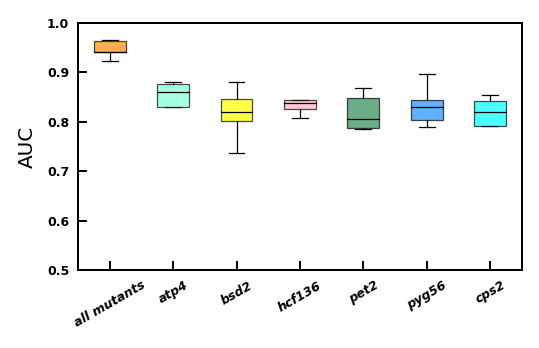

In [37]:
plt.figure(figsize=(7,4),dpi=180)
box_1, box_2, box_3, box_4, box_5, box_6, box_7 = df_box["all mutants"],df_box['ATP4'], df_box['bsd2'], df_box['hcf136'],df_box["pet2"],df_box["pyg56"],df_box["cps2"]
plt.subplot(224)
plt.tick_params(direction='in')
plt.tick_params(labelsize = 5)
color_list = ["darkorange","aquamarine","yellow","lightpink","seagreen","dodgerblue","cyan"]
medianprops = dict(linestyle='-', linewidth=0.5, color='black')
labels = ['all mutants','atp4','bsd2','hcf136',"pet2","pyg56","cps2"]
bp = plt.boxplot([box_1, box_2, box_3, box_4, box_5, box_6, box_7],notch=False, labels = labels,patch_artist = True,
            boxprops = {'color':'black','linewidth':'0.5'},
            capprops={'color':'black','linewidth':'0.5'},widths=0.5,medianprops=medianprops,whiskerprops={'linewidth':'0.5'},showfliers=False)
[bp['boxes'][i].set(facecolor=color_list[i], alpha=0.7) for i in range(7)]
plt.xticks(fontproperties = 'Times New Roman',fontstyle = "italic",size =5,fontweight = "bold") 
plt.yticks(fontproperties = 'Times New Roman',size =5,fontweight = "bold") 
plt.xticks(rotation=30)
plt.ylabel('AUC',fontsize=8)
plt.ylim((0.5, 1))